In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
sys.path.append('./../../')

from design import Design
from film import FilmSimple
from spectrum import Spectrum
from optimizer.LM_gradient_descent import LM_optimize_d_simple
from optimizer.adam import adam_optimize
import copy
from utils.loss import calculate_RMS, calculate_RMS_f_spec
import pickle
import designer
from analyze_utils.structure import plot_layer_thickness
from analyze_utils.structure import diff_simple_film


inc_ang = 0.
wls = np.linspace(400, 1000, 500)

In [16]:

def make_random_film(N, pert_budget, seed):
    np.random.seed(seed)
    d = np.random.random(N)

    d *= 3000 / np.sum(d)

    film = FilmSimple('SiO2', 'TiO2', 'Si', d_init=d)
    film.add_spec_param(0., wls)
    film_pert = copy.deepcopy(film)

    d = copy.deepcopy(d) # change reference of d to new
    pert = np.random.random(d.shape[0])
    d += pert * pert_budget / np.sum(pert)
    film_pert.update_d(d)
    return film, film_pert

def make_pert(dim, budgets, rep_num, optimizer, show=False):

    losses = []
    similarity = []
    for rep in range(rep_num):
        if show:
            print(f'dim {dim}, rep {rep}')
        losses.append([])
        similarity.append([])
        for budget in budgets:
            film, film_pert = make_random_film(dim, budget, rep)

            # plot_layer_thickness(film)
            # plot_layer_thickness(film_pert)

            # print(f'before: loss={calculate_RMS(film, film_pert)}')
            if optimizer == 'adam':
                adam_optimize(film_pert, [film.get_spec()], 1000, alpha=0.1)
            elif optimizer == 'LM':
                LM_optimize_d_simple(film_pert, [film.get_spec()], 1e-10, 1000)
            else:
                assert False, 'unsupported optimizer'
            # print(f'after: loss={calculate_RMS(film, film_pert)}')
            losses[-1].append(calculate_RMS(film, film_pert))
            similarity[-1].append(diff_simple_film(film, film_pert))
    losses = np.array(losses)
    return losses, similarity




In [14]:

layer_numbers = [2, 3, 5] + list(np.arange(10, 101, 10))
budgets=np.linspace(0, 100, 20)

# in total 260 * rep ~ 2000 GDs, or 2e6 gd steps, 2e4 s = 10 hours

In [18]:
# adam
loss_adam, sim_adam = [], []
for N in layer_numbers:
    print(f'progress: adam, {N} layers, max {layer_numbers[-1]}')
    cur_loss, cur_sim = make_pert(N, budgets, optimizer='adam', rep_num=10, show=True)
    loss_adam.append(cur_loss)
    sim_adam.append(cur_sim)
for layer, l, s in zip(layer_numbers, loss_adam, sim_adam):
    np.savetxt(f'./localmin_res/pert_loss_adam_{layer}', l)
    np.savetxt(f'./localmin_res/pert_sim_adam_{layer}', s)



progress: adam, 2layers, max 100
dim 2, rep 0
dim 2, rep 1
dim 2, rep 2
dim 2, rep 3
dim 2, rep 4
dim 2, rep 5
dim 2, rep 6
dim 2, rep 7
dim 2, rep 8
dim 2, rep 9
progress: adam, 3layers, max 100
dim 3, rep 0
dim 3, rep 1
dim 3, rep 2
dim 3, rep 3
dim 3, rep 4
dim 3, rep 5
dim 3, rep 6
dim 3, rep 7
dim 3, rep 8
dim 3, rep 9
progress: adam, 5layers, max 100
dim 5, rep 0
dim 5, rep 1
dim 5, rep 2
dim 5, rep 3
dim 5, rep 4
dim 5, rep 5
dim 5, rep 6
dim 5, rep 7
dim 5, rep 8
dim 5, rep 9
progress: adam, 10layers, max 100
dim 10, rep 0
dim 10, rep 1
dim 10, rep 2
dim 10, rep 3
dim 10, rep 4
dim 10, rep 5
dim 10, rep 6
dim 10, rep 7
dim 10, rep 8
dim 10, rep 9
progress: adam, 20layers, max 100
dim 20, rep 0
dim 20, rep 1
dim 20, rep 2
dim 20, rep 3
dim 20, rep 4
dim 20, rep 5
dim 20, rep 6
dim 20, rep 7
dim 20, rep 8
dim 20, rep 9
progress: adam, 30layers, max 100
dim 30, rep 0
dim 30, rep 1
dim 30, rep 2
dim 30, rep 3
dim 30, rep 4
dim 30, rep 5
dim 30, rep 6
dim 30, rep 7
dim 30, rep 8
dim

TypeError: _savetxt_dispatcher() missing 1 required positional argument: 'X'

In [ ]:
# LM
loss_LM, sim_LM = [], []
for N in layer_numbers:
    print(f'progress: LM, {N} layers, max {layer_numbers[-1]}')
    cur_loss, cur_sim = make_pert(N, budgets, optimizer='LM', rep_num=10, show=True)
    loss_LM.append(cur_loss)
    sim_LM.append(cur_sim)
for layer, l, s in zip(layer_numbers, loss_LM, sim_LM):
    np.savetxt(f'./localmin_res/pert_loss_LM_{layer}', l)
    np.savetxt(f'./localmin_res/pert_sim_LM_{layer}', s)


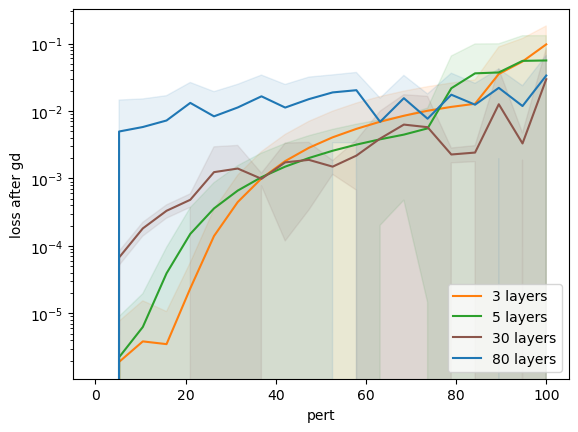

In [47]:
def plot_loss(loss, idx):
    fig, ax = plt.subplots(1, 1)
    for cur_loss, layer_number, i in zip(loss, layer_numbers, range(len(layer_numbers))):
        if i not in idx: 
            continue
        cur_std = np.std(cur_loss, axis=0)
        cur_loss = np.mean(cur_loss, axis=0)
        ax.plot(budgets, cur_loss, label=f'{layer_number} layers', c=f'C{i}')
        ax.fill_between(budgets, cur_loss - cur_std, cur_loss + cur_std, color=f'C{i}', alpha=0.1)

    ax.set_xlabel('pert')
    ax.set_ylabel('loss after gd')
    ax.set_yscale('log')
    ax.legend()

plot_loss(loss_adam, [1, 2, 5, 10])
# plot_loss(loss_LM)

In [9]:
def perturb(budget):
    f = FilmSimple('SiO2', 'TiO2', 'SiO2', np.array([100., 100.] * 20))
    # f.add_spec_param(0., np.linspace(500, 1000, 500))
    f.add_spec_param(0., np.linspace(500, 1500, 500))

    from analyze_utils.plot_spectrum import plot_spectrum

    f_target = copy.deepcopy(f)

    pert = np.random.random(f.get_d().shape[0])
    f.update_d(f.get_d() + pert * budget / np.sum(np.abs(pert)))

    adam_optimize(f, f_target.get_all_spec_list(), 500, 1e-1, show=True)
    loss = calculate_RMS(f, f_target)
    similarity = diff_simple_film(f, f_target)
    return loss, similarity

# landscape at low dimension should be: more info, fewer local minima, but not this case in higher dimensions.
# well... seems to be the guilt of LM
# TODO: exp here at low dim (2, 3, 5 layers)
loss, similarity = [], []
budgets = [10, 20, 30, 40, 50, 55, 60, 65, 70, 80, 90, 100]
for _ in range(10):
    loss.append([])
    similarity.append([])
    for budget in budgets:
        l, s = perturb(budget)
        loss[-1].append(l)
        similarity[-1].append(s)


iter 0, loss 0.0698376809120237
iter 1, loss 0.046703531732588295
iter 2, loss 0.01207114022937991
iter 3, loss 0.029275131613543115
iter 4, loss 0.05092233143027064
iter 5, loss 0.049662707126582835
iter 6, loss 0.03385661353778948
iter 7, loss 0.011785687145973401
iter 8, loss 0.013753424381184468
iter 9, loss 0.029645622226084706
iter 10, loss 0.03679365252740685
iter 11, loss 0.03598214154035771
iter 12, loss 0.028455257055299433
iter 13, loss 0.015825702127076662
iter 14, loss 0.003709071113427336
iter 15, loss 0.015106219891559776
iter 16, loss 0.023918614010162043
iter 17, loss 0.026328561751717362
iter 18, loss 0.02254351825500981
iter 19, loss 0.014263653479847586
iter 20, loss 0.004122107239299296
iter 21, loss 0.007261778595166126
iter 22, loss 0.014613709757334292
iter 23, loss 0.018223281951996313
iter 24, loss 0.017786501987516804
iter 25, loss 0.013855605725863737
iter 26, loss 0.007649388447898074
iter 27, loss 0.0024832875972279483
iter 28, loss 0.007034842740028418
it

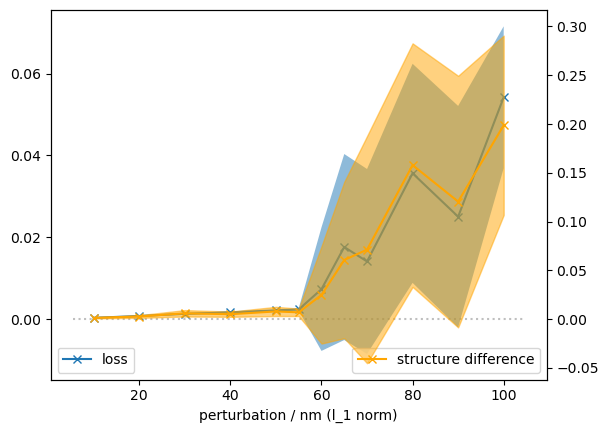

In [11]:
fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()
ax.plot(budgets, np.mean(loss, axis=0), label='loss', marker='x', zorder=1)
ax.fill_between(budgets, np.mean(loss, axis=0) + np.std(loss, axis=0), np.mean(loss, axis=0) - np.std(loss, axis=0), alpha=0.5, zorder=10)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[-1]], [0, 0], c='grey', alpha=0.5, ls=':')
ax2.plot(budgets, np.mean(similarity, axis=0), label='structure difference', marker='x', c='orange')
ax2.fill_between(budgets, np.mean(similarity, axis=0) - np.std(similarity, axis=0), np.mean(similarity, axis=0) + np.std(similarity, axis=0), color='orange', alpha=0.5, zorder=11)
ax.legend()
ax2.legend(loc='lower right')
ax.legend(loc='lower left')
ax.set_xlabel('perturbation / nm (l_1 norm)')
def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = (ax1, ax2) 
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])
align_yaxis(ax, ax2)